In [1]:
%load_ext rpy2.ipython

/home/eltem/miniconda3/envs/SA-conf/lib/python3.12/site-packages/rpy2/ipython/rmagic.py:77: UserWarning: The Python package `pandas` is strongly recommended when using `rpy2.ipython`. Unfortunately it could not be loaded (error: No module named 'pandas'), but at least we found `numpy`.
  warnings.warn('The Python package `pandas` is strongly '


In [2]:
%%R -w 800 -h 480
#--------------------------------------------------------------------
#--------------------------------------------------------------------
# This R script was made to explore the different ways to plot the 
# b-factor for the program SA-conf
#
# Author : Eliott TEMPEZ
# M2 Bioinformatique
# December 2024
#--------------------------------------------------------------------
#--------------------------------------------------------------------


#--------------------------------------------------------------------
# Read files
#--------------------------------------------------------------------
setwd("/home/eltem/Documents/Cours/M2/projet_long")
folder_out = "saconf_out"
source(paste(folder_out, "params.R", sep="/"))

Listpdb = as.character(read.table(file1)[,1])

fileLS = paste(pathsaconf,"SL_alignment.fasta2_wo_header.aln", sep="/")
LS = read.table(fileLS)

fileAA = paste(pathsaconf,"AA_alignment.fasta2_wo_header.aln", sep="/")
AA = read.table(fileAA)

file.res = paste(pathsaconf, "res_info.csv", sep="/")
infoRes = read.csv(file.res)

file.position = paste(pathsaconf, "position_alignment.fasta2", sep="/")
ali = read.table(file.position)
ali = as.data.frame(ali[seq(2, dim(ali)[1], 2), ])


#--------------------------------------------------------------------
# Variable definition
#--------------------------------------------------------------------
#AA
AlphabetAA = c("-","A","I","L","M","F","W","V","R","K","N","Q","S","T","C","E","D","G","H","Y","P")
VectcolAA = c("black", "purple4","blue4","skyblue4","blue1","skyblue","paleturquoise2","lightblue1","red1","red3", "olivedrab1","green","green3","olivedrab4","pink","magenta1","magenta3","orange","cyan1", "cyan4","yellow2")
names(VectcolAA) =  AlphabetAA[1:length(AlphabetAA)]      


#SL
Alphabet=c("-","a","A","V","W","Z","B","C","D","E","O","S","R","Q","I","F","U","P","H","G","Y","J","K",
           "L","N","M","T","X")
VectcolSL=c("black","red4","red","indianred3", "tomato2","orange","yellow","yellow3","seashell2","mistyrose1","pink","violet","pink3","purple","purple4","lavenderblush4","blue","steelblue","cyan","paleturquoise","powderblue","palegoldenrod",'bisque4',"darkcyan","green","yellowgreen","olivedrab4","khaki4")
names(VectcolSL) =  Alphabet[1:length(Alphabet)]  


#--------------------------------------------------------------------
# Functions
#--------------------------------------------------------------------
computNeq = function(mat){
  mat[mat == "-"] = NA
  neqVect = NULL
  for (i in 1:dim(mat)[2]){
    vect = mat[which(mat[,i]!="NA"),i]
    pourc = length(vect)/dim(mat)[1]
    if (pourc < 0.50){
      neq = 0
    }else{
      freq = table(vect) / sum(table(vect))
      H = - sum(freq * log(freq))
      neq = exp(H)
    }
    neqVect = c(neqVect, neq)
  }
  return(neqVect)
}


getBfactMat = function(infoRes, ali, listPDB) {
  matBfact = matrix(NA, dim(ali)[1], dim(ali)[2])
  for (i in seq_len(dim(matBfact)[1])) {
    pdbName = listPDB[i]
    Pdb = unlist(strsplit(pdbName, "_"))[1]
    Chain = unlist(strsplit(pdbName, "_"))[2]
    info = subset(infoRes, pdb == Pdb & chain == Chain)
    for (j in seq_len(dim(matBfact)[2])) {
      resnum = ali[i, j]
      if (resnum != "-") {
        resnum = as.numeric(resnum)
        bFact = info[info$resnum == resnum, "bfact"]
        matBfact[i, j] = bFact
      }
    }
  }
  return(matBfact)
}


#--------------------------------------------------------------------
# Compute neq(LS)
#--------------------------------------------------------------------
tailleLS = length(unlist(strsplit(as.character(LS[1,]), "")))
matLS = matrix(NA, ncol=tailleLS, nrow=dim(LS)[1])
matNum = matrix(NA,ncol = tailleLS, nrow=dim(LS)[1])
# Get alignment
for (i in 1:dim(LS)[1]){
  ligne = as.character(ali[i,])
  vect = unlist(strsplit(ligne,"\\."))
  matNum[i,] = vect
}
for (i in 1:dim(LS)[1]){
  ligne = as.character(LS[i,])
  vect = unlist(strsplit(ligne,""))
  matLS[i,] = vect
}
# Calculate neq
neqLSVect = computNeq(matLS)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


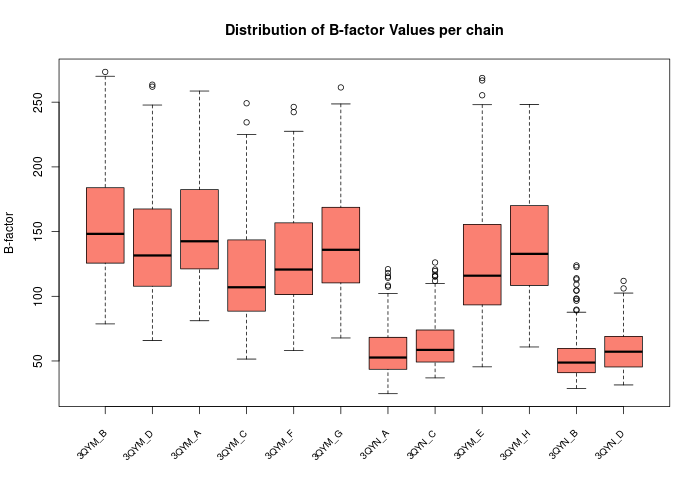

In [3]:
%%R -w 700 -h 480
#--------------------------------------------------------------------
# Get and plot b-factor
#--------------------------------------------------------------------
matBfact = getBfactMat(infoRes, matNum, Listpdb)

boxplot(t(matBfact), main = "Distribution of B-factor Values per chain", xlab = "", 
        xaxt = "n", ylab = "B-factor", col = "salmon", outline = TRUE)
axis(1, at = 1:nrow(matBfact), labels = FALSE)
text(x = 1:nrow(matBfact), y = par("usr")[3] - 20, labels = Listpdb, 
     srt = 45, adj = 1, xpd = TRUE, cex = 0.8)

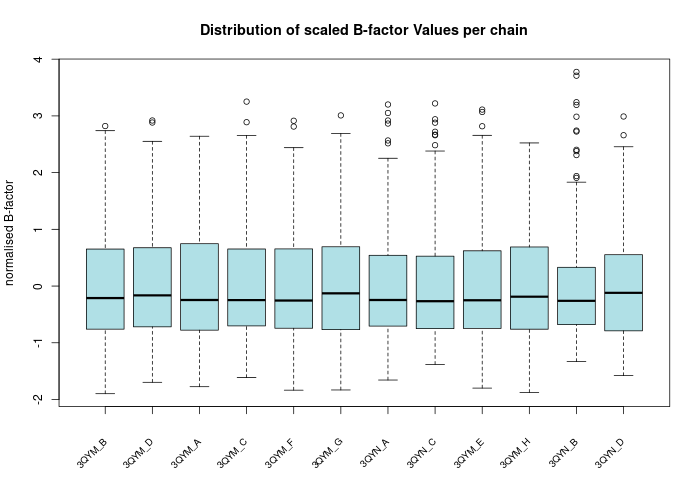

In [4]:
%%R -w 700 -h 480
#--------------------------------------------------------------------
# Normalise b-factor
#--------------------------------------------------------------------
matBfactScale = t(apply(matBfact, 1, scale))

boxplot(t(matBfactScale), main = "Distribution of scaled B-factor Values per chain", xlab = "", 
        xaxt = "n", ylab = "normalised B-factor", col = "powderblue", outline = TRUE)
axis(1, at = 1:nrow(matBfactScale), labels = FALSE)
text(x = 1:nrow(matBfactScale), y = par("usr")[3] - 0.6, labels = Listpdb, 
     srt = 45, adj = 1, xpd = TRUE, cex = 0.8)

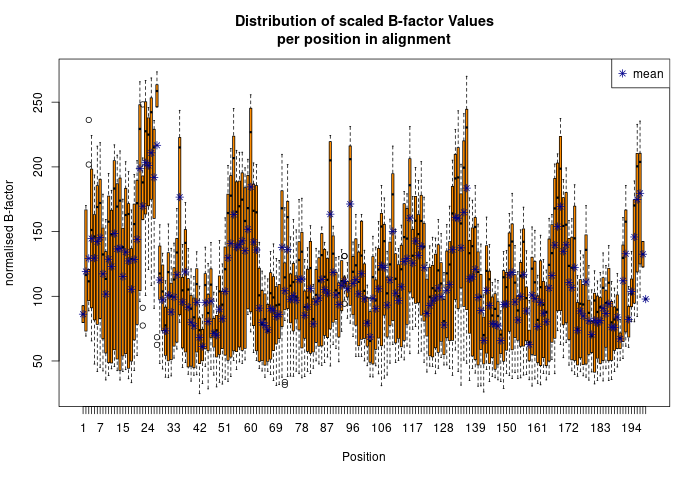

In [5]:
%%R -w 700 -h 480
#--------------------------------------------------------------------
# Plot b-factor per position
#--------------------------------------------------------------------
# Before normalisation
boxplot(matBfact, main = "Distribution of scaled B-factor Values\nper position in alignment", xlab = "Position", 
        ylab = "normalised B-factor", col = "darkorange", outline = TRUE)
points(1:dim(matBfact)[2], colMeans(matBfact, na.rm = TRUE), col = "darkblue", pch = 8)
legend("topright", legend = "mean", col = "darkblue", pch = 8)

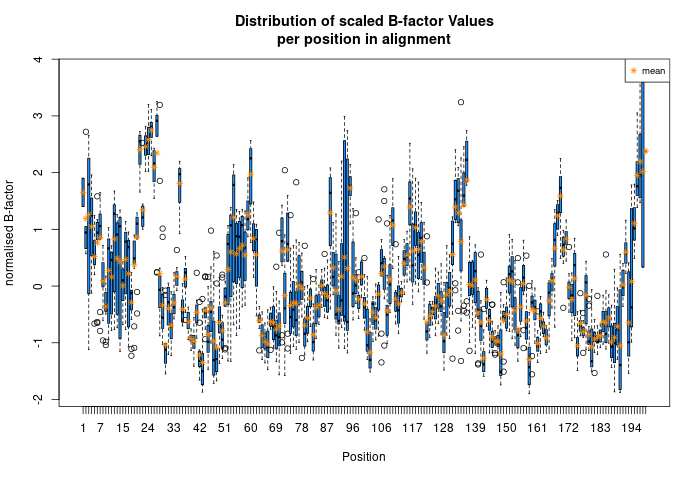

In [6]:
%%R -w 700 -h 480

# After normalisation
boxplot(matBfactScale, main = "Distribution of scaled B-factor Values\nper position in alignment", xlab = "Position", 
        ylab = "normalised B-factor", col = "dodgerblue", outline = TRUE)
points(1:dim(matBfactScale)[2], colMeans(matBfactScale, na.rm = TRUE), col = "darkorange", pch = 8, cex = 0.8)
legend("topright", legend = "mean", col = "darkorange", pch = 8, cex = 0.8)